In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from definitions import ROOT_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from seriate import seriate
from scipy.spatial.distance import pdist
from plotnine import *

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':12})

- Inputs

In [2]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
#p_out = p_root_dir / "6_plots/q2_plots/dot_plots"
p_out = p_root_dir / "6_plots/Interlab"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "2022-06-17_All_Interlab_Predictions.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_01_June_2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

- Merge relevant info into one dataframe

In [3]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

# TODO: remove thermometer ions

chem_class = pd.read_csv(p_chem_class, index_col='internal_id')
main_chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()
pathways = pd.read_csv(p_pathways, index_col='internal_id')
main_pathways = pathways[['name_short', 'main_coarse_path']].drop_duplicates()

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'Participant lab', 'Technology', 'Interlab']] # 'Participant lab', 'Technology'
datasets_info['sample_name'] = datasets_info['Slide code'] + ': ' + datasets_info['Technology']
#datasets_info['sample_name'] = datasets_info['Matrix short']
# datasets_info['sample_name'] = datasets_info['Matrix short'] + '_' + datasets_info['Slide code']

# Merge with predictions and classification
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')
df=df[df['Interlab']]

### Heatmap

In [4]:
def filter_neutral_losses(df, filter_on=True, neutral_losses_to_keep=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.neutral_loss.isin(neutral_losses_to_keep)]
    elif filter_on == 'only_nl':
        df = df[df.neutral_loss != '']
    return df

def calculate_detected_intensities(df):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    '''
    intensities_for_twostate_spots = (df.pred_twostate == 1) * df.spot_intensity_bgr_corrected
    df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
    intensities_for_threestate_spots = (df.pred_threestate == 2) * df.spot_intensity_bgr_corrected
    df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
    return df

def filter_polarity(df, polarity):
    '''
    Filter out entries based on polarity pol ['pos', 'neg']
    '''
    return df[df['Polarity'] == polarity]

def group_by_molecule(df, intensity_col_name, prediction_col_name):
    '''
    Aggregate intensity and detection values per class
    '''
    
    if intensity_col_name == 'val_threestate':
        intensity_aggregation_func = lambda x: (x==2).any()
    else: intensity_aggregation_func = lambda x: (x==1).any()
            
    
    data = df.pivot_table(index=['name_short'],
                          columns=['sample_name'],
                          values=[intensity_col_name, prediction_col_name],
                          aggfunc = {
                                intensity_col_name : lambda x: np.log10(sum(x)+1),
                                prediction_col_name : intensity_aggregation_func
                          },
                          fill_value=0,)
    data = data.stack(level=1, dropna=False).reset_index()
    # If no ions on a molecule were detected by matrix, prediction column contains fill value 0 instead of False, correct for that:
    data.at[data[prediction_col_name] == 0, prediction_col_name] = False
    return data

def prep_molecule_data(data, polarity,  intensity_col_name, prediction_col_name, nl_filter_on=False, neutral_losses_to_keep=None):
    '''
    '''
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = calculate_detected_intensities(data)
    data = filter_polarity(data, polarity)
    data = group_by_molecule(data, intensity_col_name, prediction_col_name)
    
    return data

def summarise_per_fine_class(df, fine_class_col_name, coarse_class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] =1
    data = df.pivot_table(index=['sample_name'],
                                   columns=[fine_class_col_name, coarse_class_col_name],
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0)
    
    data = data.stack(level=[1,2], dropna=True).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')
    # sort rows first by coarse class, then by fine class
    data = data.sort_values(by=[coarse_class_col_name, fine_class_col_name])
    return data

def summarise_per_coarse_class(df, class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] = 1
    data = df.pivot_table(index=['sample_name'],
                                   columns=class_col_name,
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0)
    
    data = data.stack(level=1, dropna=False).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']
    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')    
    return data

<ipython-input-4-cf286576d5d9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-4-cf286576d5d9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-4-cf286576d5d9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-4-cf286576d5d9>:

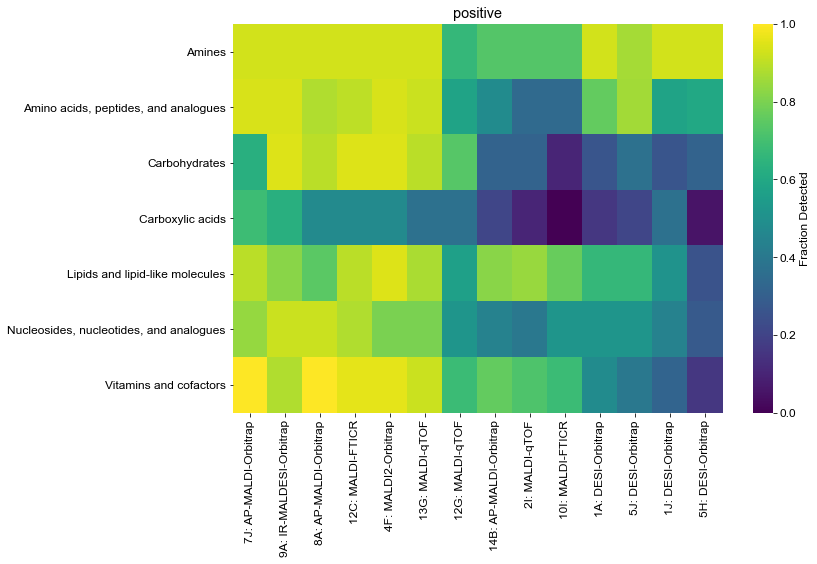

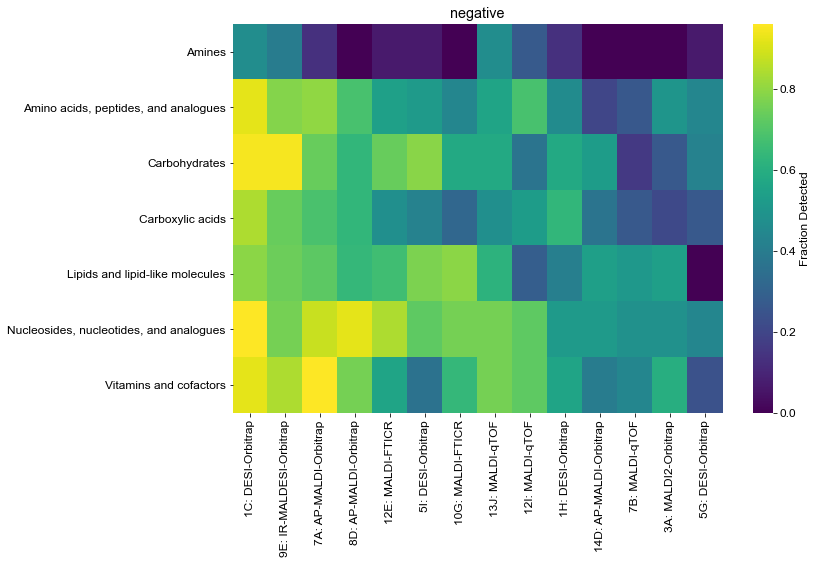

In [5]:
for pol in ['positive', 'negative']:
    molecule_data = prep_molecule_data(df[df['Interlab']],
                                       polarity=pol, 
                                       nl_filter_on=True, 
                                       neutral_losses_to_keep=[''], 
                                       intensity_col_name= 'val_threestate',
                                       prediction_col_name = 'pred_threestate')

    # Map chemical classes
    mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

    class_data = summarise_per_coarse_class(mapped_data,
                                                class_col_name='main_coarse_class',
                                                intensity_col_name= 'val_threestate',
                                                prediction_col_name = 'pred_threestate')


    plot_data = class_data.pivot_table(index = ['sample_name'],
                                           columns=['main_coarse_class'],
                                           values=['fraction_detected'],
                                           aggfunc = {
                                                'fraction_detected':sum,
                                           },
                                           fill_value=0).T
    plot_data = plot_data.reindex(columns=plot_data.columns[seriate(pdist(plot_data.T.to_numpy()))])


    plt.figure(figsize=(12,8))

    g = sns.heatmap(data=plot_data, 
                    yticklabels=plot_data.index.get_level_values(1), 
                    cmap='viridis',
                    cbar_kws={'label': 'Fraction Detected'}
                   )

    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(f"{pol}")
    plt.xlabel("")
    plt.ylabel("")
    #plt.xticks(rotation=90)
    plt.tight_layout()
    g.figure.savefig(p_out / f"Heatmap_{pol}.png")